# Obtaining and visualising voting data using Wikipedia and Python: an example using the 2021 Portuguese Presidential Elections

*Frederico Muñoz*, 2021.

----

## Introduction

While open data is increasingly made available by public and private institutions it's not always possible to use it for specific purposes. In the case of elections it's not uncommon for the final and officially approved data to take months (if not years) to be made available, which impairs the ability to react quickly to ongoing political events.

One possibility is to manually collect information as it is made available, and this is where Wikipedia can become a very useful source of structured data: Wikipedia editors and volunteers create and update voting data to enrich the articles on the election process. This data is not available in a "ready to consume" form but it *is* structured.

In this short notebook we will see how to find the right data, process it and then use it to visualise results; for this we will use **GeoPandas** to display voting bondaries based on a **GeoJSON** file, enrich a **GeoDataFrame** with the extracted elections results and analyse the voting patterns using a **cloropeth map**.


*NB: the debate about the reliability of Wikipedia as a source of information is outside the scope of this notebook.*

## Identifying and obtaining  the data

The article on the 2021 Presidential Elections in Portugal is available at https://pt.wikipedia.org/wiki/Elei%C3%A7%C3%B5es_presidenciais_portuguesas_de_2021 ; we will be using the Portuguese wikipedia article since it is the one that has the updated information in table form.

There are several ways to present the data; in this notebook we will use the Municipality (*Concelho*) as the smallest unit since that's the smallest one available at the page (the smallest unit, the parish (*freguesia*), is the one directly below this one, one *concelho* being composed of one or more parishes).

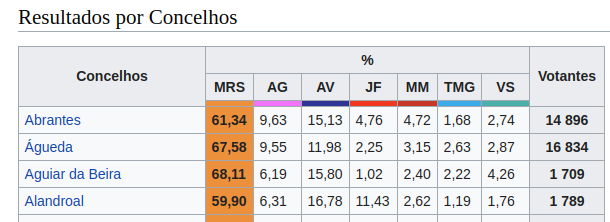

Checking the page source we can find the relevant table and observe the markdown that identifies it.

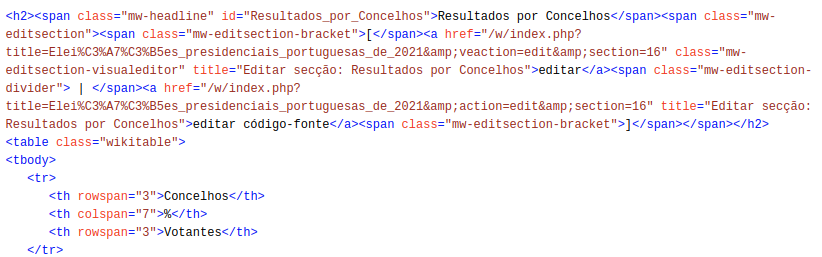

**Specifically, we see that we have a table that comes after a `span` with and `id` of `Resultados_por_Concelhos`**.

With that information we now proceed to get the entire Wikipedia article for further processing:

In [1]:
import requests
from bs4 import BeautifulSoup

wurl="https://pt.wikipedia.org/wiki/Elei%C3%A7%C3%B5es_presidenciais_portuguesas_de_2021"
session = requests.Session()
wpage= session.get(wurl,timeout=10)

We have the entire HTML page as a big string of characters; using `BeautifulSoup` we can parse it and turn it into a structure JSON object.

In [2]:
soup = BeautifulSoup(wpage.text, 'html.parser')
soup.title

<title>Eleições presidenciais portuguesas de 2021 – Wikipédia, a enciclopédia livre</title>

We make use of that to search for our table: the one that immediately follows a `span` with a specific `id`:

In [3]:
table = soup.find('span',{"id": "Resultados_por_Concelhos"}).find_next("table")
table["class"]

['wikitable']

The HTML table is "structured", albeit not the easiest format to immediately consume: we must turn the rows and the cells into a tabular format. The following code achieves that: it identifies the header rows by the number of cells, builds the header (what will be the first row), and then adds the results of all municipalities for all candidates. The result is a list of dictionaries, one for each municipality.

In [4]:
import collections

header=[]
results_list = []
for row in table.findAll('tr'):
    votes_dict = collections.OrderedDict()
    cells=row.findAll(["td", "th"])
    if len(cells) == 3:
        for cell in cells:
            t = cell.find(text=True).rstrip()
            header.append(t)
        header.remove("%")
    if len(cells) == 7:
        for cell in cells:
            t = cell.find(text=True).rstrip()
            if t != "":
                header.append(t)
        header.append(header.pop(header.index('Votantes')))
        #print(row)
    if len(cells) == 9:
        for cell,head in zip(cells,header):
            t = cell.find(text=True).rstrip().replace(",",".")
            #print(head + ": "+ t +".")
            votes_dict[head]=t
        results_list.append(votes_dict)

## Show the first entry of the list
results_list[0]

OrderedDict([('Concelhos', 'Abrantes'),
             ('MRS', '61.34'),
             ('AG', '9.63'),
             ('AV', '15.13'),
             ('JF', '4.76'),
             ('MM', '4.72'),
             ('TMG', '1.68'),
             ('VS', '2.74'),
             ('Votantes', '14 896')])

This format - list of dictionaries - is particularly suited for what we will do next: the creation of a `pandas` dataframe:

In [5]:
import pandas as pd
res_df = pd.DataFrame(results_list)
res_df.head()

,Concelhos,MRS,AG,AV,JF,MM,TMG,VS,Votantes
0,Abrantes,61.34,9.63,15.13,4.76,4.72,1.68,2.74,14 896
1,Águeda,67.58,9.55,11.98,2.25,3.15,2.63,2.87,16 834
2,Aguiar da Beira,68.11,6.19,15.80,1.02,2.40,2.22,4.26,1 709
3,Alandroal,59.90,6.31,16.78,11.43,2.62,1.19,1.76,1 789
4,Albergaria-a-Velha,68.93,9.10,10.97,1.96,3.43,2.35,3.26,9 365


Trough trial-and-error there were some aspects of the dataframe that need to be tweaked a tiny bit: remove the space separator from numbers and convert the numeric columns to a numeric type (a float for all, although an int could be used for the "Votantes" - *Voters* -  column).

In [6]:
#res_df["Concelhos"]=res_df["Concelhos"].str.upper()
res_df["Votantes"] = res_df["Votantes"].str.replace(" ","")
repl= res_df.iloc[:, 1:9].astype(float)
res_df[repl.columns]=repl
res_df.dtypes

Concelhos     object
MRS          float64
AG           float64
AV           float64
JF           float64
MM           float64
TMG          float64
VS           float64
Votantes     float64
dtype: object

This dataframe would enable us, by itself, to perform all sorts of interesting analysis, but the focus of this notebook is how to present it in a map - and for that we will use GeoPandas.

## Visualising data on a map

Visualising electoral results is often done through a cloropeth map; for that we need:

- **The coordinates of the different areas (in our case, municipalities) we want to represent**: for this we will use a GeoJSON file which is a simplified version of the one made available by the Direcção Geral de Território (https://snig.dgterritorio.gov.pt/rndg/srv/por/catalog.search#/search?facet.q=dataPolicy%2FDados%2520abertos&resultType=details&sortBy=referenceDateOrd&anysnig=CAOP2019&from=1&to=20&fast=index&_content_type=json&type=dataset%2Bor%2Bseries), which is a good example of providing access to open data using open standards and formats. 
- **The data we want to visualise**: we already have this from the previous step.
- A way to programatically combine the information and display it: for this we will use **GeoPandas** and **geoplot**

We start by importing the necessary libraries and setting up some options:

*NB: We are using a version of the file that only contains Continental Portugal, since the data for overseas territories is made available using different files which would add a small ammount of complexity in processing them; the approach would however be the same.*

In [7]:
import geopandas
import geoplot
import pyproj
from matplotlib import pyplot as plt
## This might be needed, or not, depending on where the noteook runs
pyproj.datadir.set_data_dir("/usr/local/share/proj")

The GeoJSON file was added to the repository and we can obtain it directly from the URL

In [8]:
geo_file="https://raw.githubusercontent.com/fsmunoz/pt-act-parlamentar/presidenciais2021/concelhos_cont1.json"
municipality_boundaries = geopandas.read_file(geo_file)

Using `geoplot` it's very simple to produce a map of the imported bondaries.

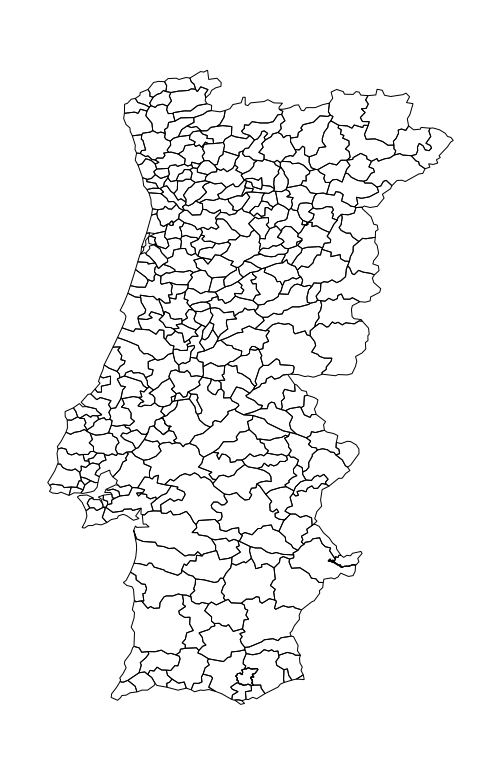

In [9]:
geoplot.polyplot(municipality_boundaries, figsize=(18, 14))

We now have a map and we have a dataframe with the information we want to visualise: we now combine them into a single `GeoDataFrame` object, essentially a regular Pandas dataframe that has a column named `geometry` with the geographic information.

The GeoJSON file was imported into a GeoDataFrame object already, and we can see that the column `NAME_2` is the one that contains the name of the Municipality:

In [10]:
municipality_boundaries.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,,,"POLYGON ((-7.72069 38.68486, -7.77012 38.75388..."
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,,,"POLYGON ((-7.22761 38.76683, -7.26394 38.77336..."
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,,,"POLYGON ((-7.78996 38.89579, -7.86466 38.90903..."
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,,,"POLYGON ((-7.41777 38.86806, -7.42294 38.90348..."
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,,,"POLYGON ((-7.46612 38.92604, -7.45290 38.96442..."


With that we can merge the dataframe we have with the results to it, specifying that the column `NAME_2` in one and `Concelhos` in the other should be matched. The result is a single GeoDataFrame with all the information from both dataframes.

In [11]:
geodata = municipality_boundaries.merge(res_df, how='inner', left_on=["NAME_2"], right_on=["Concelhos"])
geodata.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,...,geometry,Concelhos,MRS,AG,AV,JF,MM,TMG,VS,Votantes
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,...,"POLYGON ((-7.72069 38.68486, -7.77012 38.75388...",Évora,54.78,12.19,16.59,7.92,4.06,2.74,1.73,21847.0
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,...,"POLYGON ((-7.22761 38.76683, -7.26394 38.77336...",Alandroal,59.90,6.31,16.78,11.43,2.62,1.19,1.76,1789.0
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,...,"POLYGON ((-7.78996 38.89579, -7.86466 38.90903...",Arraiolos,53.37,8.64,10.99,19.12,4.60,1.31,1.97,2959.0
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,...,"POLYGON ((-7.41777 38.86806, -7.42294 38.90348...",Borba,57.29,9.41,18.37,7.91,3.39,1.90,1.74,2524.0
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,...,"POLYGON ((-7.46612 38.92604, -7.45290 38.96442...",Estremoz,53.22,10.46,23.32,6.73,2.93,1.52,1.83,4837.0


We now have the information we need to plot the cloropeth map by specifying the column we want to focus on, like the number of voters in each municipality.

Text(0.5, 1.0, 'Number of voters')

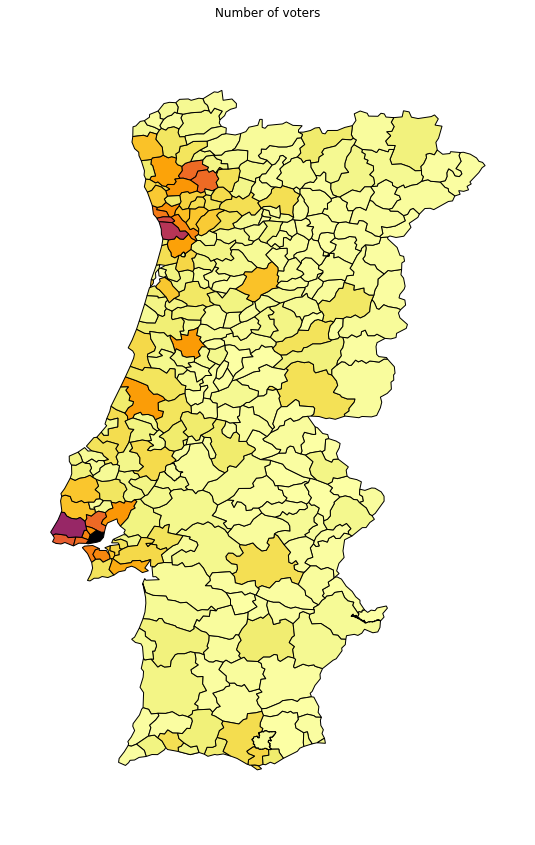

In [12]:
geoplot.choropleth(geodata, hue=geodata["Votantes"],cmap="inferno_r", figsize=(15,15))
plt.title("Number of voters")

With a bit more work (mostly around setting up the grid and arranging the subplots) we are able to produce a single plot composed of subplots: 7 showing the precentages of each candidate plus a final one with the same information as above.

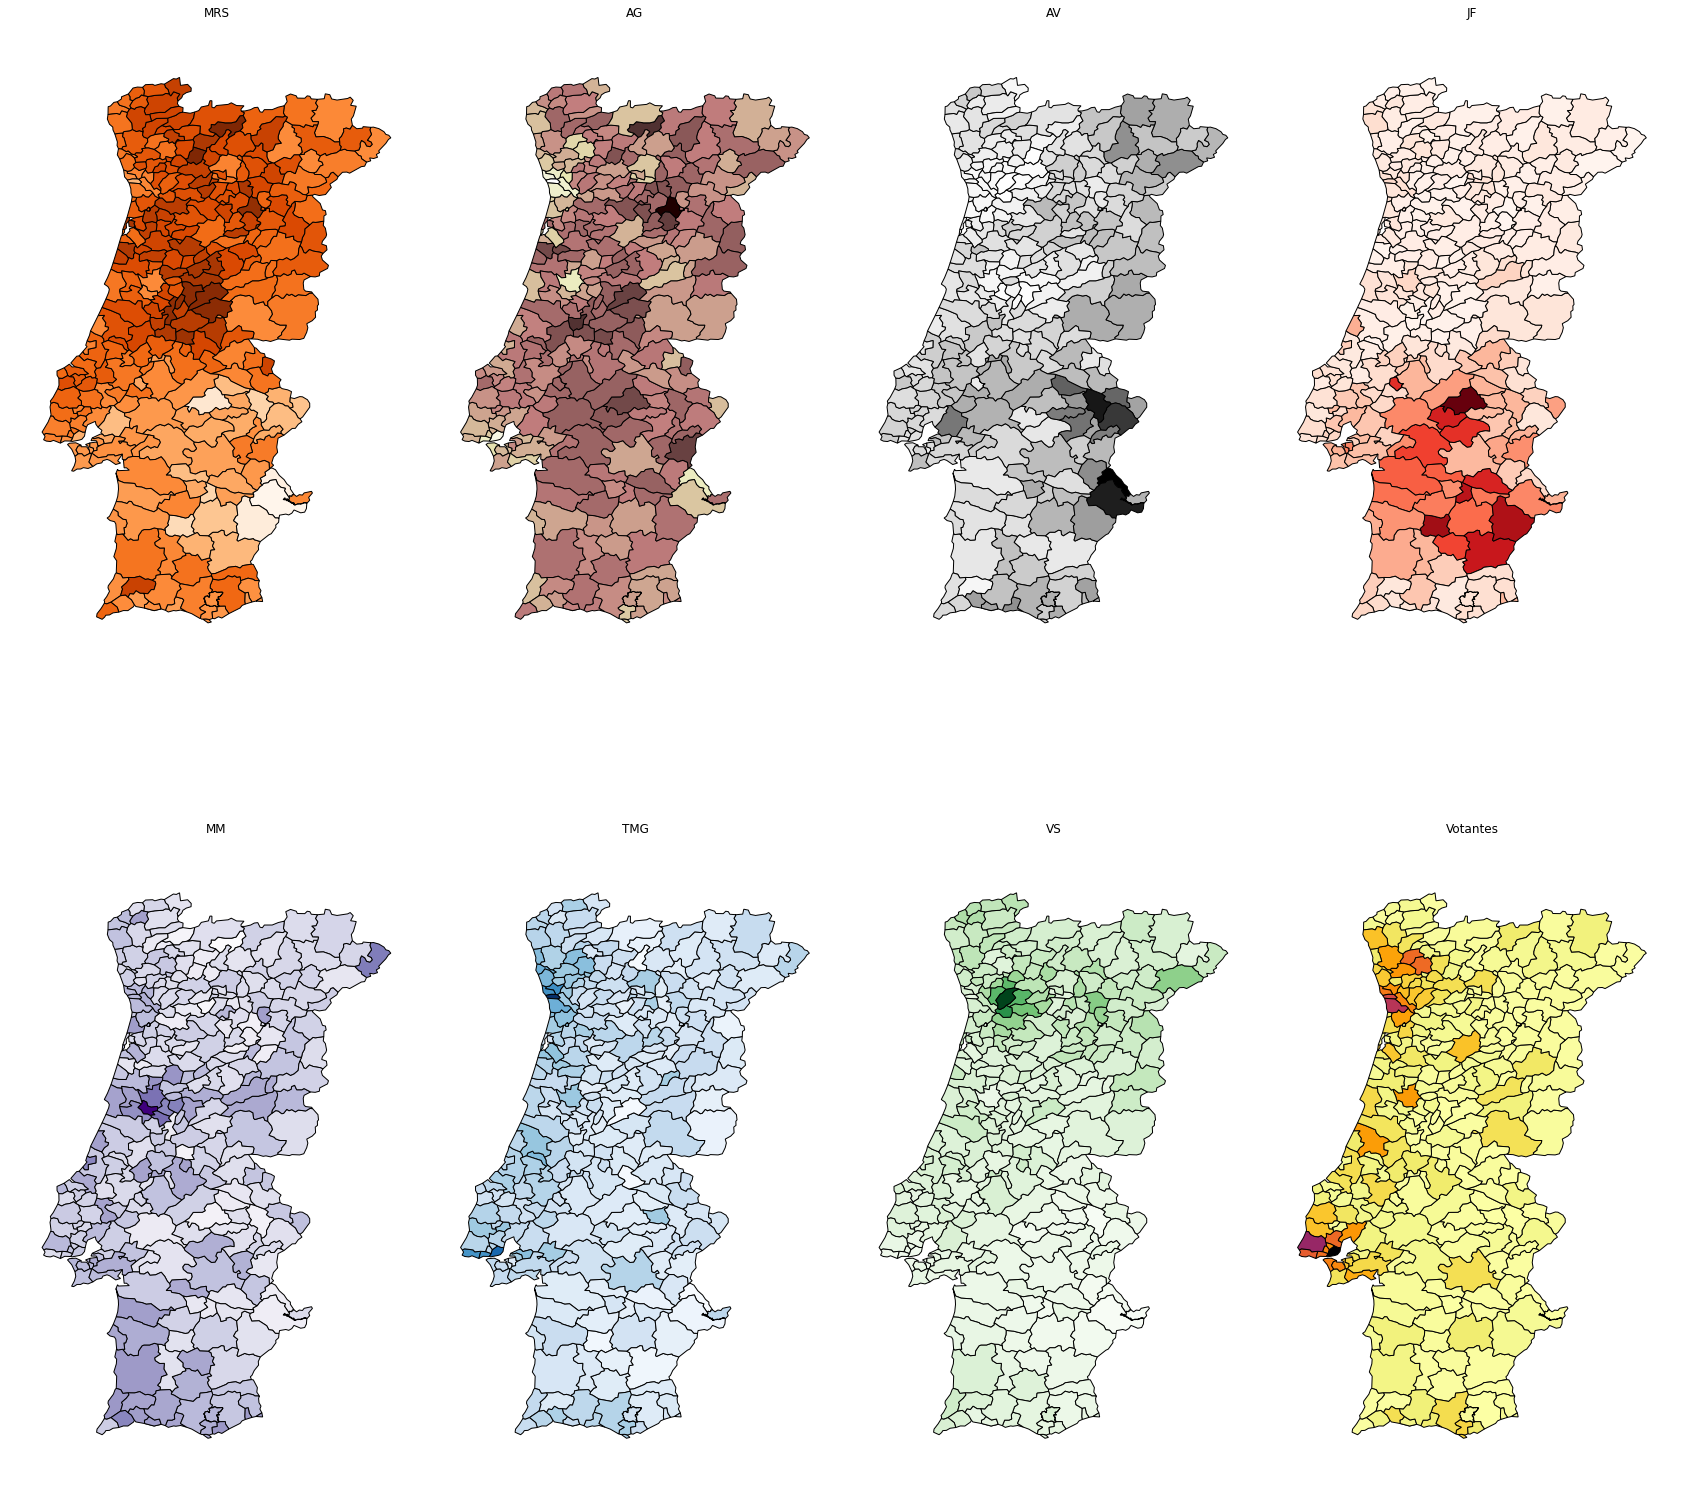

In [13]:
import matplotlib.pyplot as plt

## Mostly randomly chosen after assigning the most obvious ones
cmap_dict = {
  "MRS": "Oranges",
  "AG": "pink",
  "AV": "Greys",
  "JF": "Reds",
  "MM": "Purples",
  "TMG": "Blues",
  "VS": "Greens",
  "Votantes": "inferno_r"
}

## 2x4 matrix
fig, axes = plt.subplots(ncols=4, nrows=2,figsize=(30,30))

for a, candidate in enumerate(res_df.columns[1:9]):
    if a < 4:
        haxis=0
        correct=0
    else:
        haxis=1
        correct=4
    geoplot.choropleth(geodata, hue = geodata[candidate], cmap=cmap_dict[candidate], ax=axes[haxis][a-correct])
    axes[haxis, a-correct].set_title(candidate)   

plt.subplots_adjust(wspace=0, hspace=0)

And that's it!

## Final thoughts

This example is relatively straightforward and can be enhanced in many ways: once we built the main GeoDataFrame it's easy to come up with additional sources of information that can be added as well, from other sources. Additionally, plots are not limited to cloropeth maps: the dataframe we have built can be used for both geographic visualisation through GeoPandas (and other tools) and as the basis for more quantitative analysis such as analysis of variance,etc.